# Experimento05: Redes Recurrentes Apiladas

## Librerías

In [2]:
# Librerias necesarias
import os

# Matplotlib conf
import matplotlib.pyplot as plt
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':40,
         'ytick.labelsize': 40
}
plt.rcParams.update(params)
# Seaborn conf
import seaborn as sns
sns.set(style='darkgrid')
sns.set_palette(sns.color_palette("Blues"))

import sys

#Procesado de datos
import pandas as pd
import numpy as np
import operator

#Modelos
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')


from sklearn.decomposition import TruncatedSVD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing
from nltk import ngrams

from keras.layers import Dense, Embedding, Flatten, GlobalMaxPool1D, Dropout
from keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from tensorflow.keras import regularizers

from keras.initializers import Constant

from wordcloud import WordCloud

from sklearn.decomposition import TruncatedSVD
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import plot_model
import tensorflow as tf

from sklearn import preprocessing
from nltk import ngrams

from tensorflow.keras import regularizers

## Carga de conjunto de datos

In [3]:
df_training = pd.read_csv("./data/ds_training_processed.csv")
df_testing = pd.read_csv("./data/ds_testing_processed.csv")

X_train = df_training["text"]
y_train = df_training["sentiment"]
X_test = df_testing["text"]
y_test = df_testing["sentiment"]

y_train_2 = to_categorical(y_train, num_classes=2)
y_test_2 = to_categorical(y_test, num_classes=2)

## Carga de modelos de representación

In [4]:
def load_representation_model(file_name, include_embedding_matrix=False):
    res = {}
    with open("./repmodels/"+file_name+".txt", 'r') as d:
        res["model"] = d.readline()
    res["train_text_features"] = np.load("./repmodels/"+file_name+"_train.npy")
    res["test_text_features"] = np.load("./repmodels/"+file_name+"_test.npy")

    if include_embedding_matrix:
        res["embedding_matrix"] = np.load("./repmodels/"+file_name+"_embeddingmatrix.npy")

    return res

vsm_binary = load_representation_model("vsm_binary")
vsm_binary_ngrams = load_representation_model("vsm_binary_ngrams")
vsm_tfidf = load_representation_model("vsm_tfidf")
vsm_tfidf_ngrams = load_representation_model("vsm_tfidf_ngrams")
embedding_padding = load_representation_model("embedding_padding")
embedding_glove = load_representation_model("embedding_glove", include_embedding_matrix=True)

# Cargo esto por facilidad
vsm_model = []
vsm_model.append(vsm_binary)
vsm_model.append(vsm_binary_ngrams)
vsm_model.append(vsm_tfidf)
vsm_model.append(vsm_tfidf_ngrams)

## Funciones generales

In [5]:
pd.set_option('display.max_colwidth', 2000)
vocab_size = 29773
emb_dim = 50
num_words = 29773

results = []
def add_to_results(classifier, repmodel, predict_x, y_test):
    y_pred = np.argmax(predict_x,axis=1)

    results.append({"classifier": classifier,
                    "rep.model": repmodel,
                    "accuracy": accuracy_score(y_test, y_pred),
                    "precision": precision_score(y_test, y_pred, average="weighted"),
                    "recall": recall_score(y_test,y_pred, average="weighted")
                    })

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'bo', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel("Epochs")
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

def nn_classification_report(predict_x, y_test, class_names):
    y_pred = np.argmax(predict_x,axis=1)

    print("Classification Report")
    print

    print(classification_report(y_true=y_test, y_pred=y_pred, target_names=class_names))
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

    plot_confusion_matrix(cm, classes=class_names)

    print("Final Accuracy")
    print(accuracy_score(y_test, y_pred))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def join_csv_for_experiment(experiment_string, number_of_experiements):
    experiments_data = []
    for i in range(1, number_of_experiements+1):
        experiments_data.append( pd.read_csv("exp_"+experiment_string+"_"+str(i)+".csv") )

    res = pd.concat(experiments_data, ignore_index=True)
    res.to_csv("exp_"+experiment_string+".csv")

## Clasificadores

In [6]:
def build_exp05(
        name, 
        description, 
        rep,
        input_shape,
        embedding=None,
        exp="Exp05",
        layers_units=[64, 64],
        extra_dense_layer_nn=0,
        extra_dense_dropout_layer=0.0,
        dropout=[0.0, 0.0],
        recurrent_dropout=[0.0, 0.0],
        kernel_regularizer=None
        ):
    callbacks = [
        keras.callbacks.EarlyStopping(
                monitor='val_loss', 
                mode='min', 
                patience=3, 
                min_delta=0.01)        
    ]    
    inputs = keras.Input(shape=input_shape, dtype="float")

    return_sequences = False
    if len(layers_units)>1:
        return_sequences = True

    if embedding:
        x = embedding(inputs)
        x = layers.SimpleRNN(layers_units[0], 
                             return_sequences=return_sequences, 
                             dropout=dropout[0], 
                             recurrent_dropout=recurrent_dropout[0], 
                             kernel_regularizer=kernel_regularizer)(x)
    else:
        x = layers.SimpleRNN(layers_units[0], 
                             return_sequences=return_sequences, 
                             dropout=dropout[0], 
                             recurrent_dropout=recurrent_dropout[0], 
                             kernel_regularizer=kernel_regularizer)(inputs)

    if return_sequences:
        layers_units.pop(0)
        for i, _ in enumerate(layers_units[:-1]):
            x = layers.SimpleRNN(layers_units[i], 
                                 return_sequences=True, 
                                 dropout=dropout[i], 
                                 recurrent_dropout=recurrent_dropout[i], 
                                 kernel_regularizer=kernel_regularizer)(x)
        x = layers.SimpleRNN(layers_units[-1], 
                             return_sequences=False, 
                             dropout=dropout[-1], 
                             recurrent_dropout=recurrent_dropout[-1], 
                             kernel_regularizer=kernel_regularizer)(x)

    if extra_dense_layer_nn > 0:
        x = layers.Dense(extra_dense_layer_nn, activation="relu")(x)
        if extra_dense_dropout_layer > 0:
            x = layers.Dropout(extra_dense_dropout_layer)(x)
    
    outputs = layers.Dense(2, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model._name = exp+name
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    print(model.summary())
    history = model.fit(rep["train_text_features"].astype(float), 
                        y_train_2, 
                        epochs=40,
                        batch_size=32,
                        validation_split=0.2, 
                        callbacks=callbacks)
    plot_history(history)
    predict_x=model.predict(rep["test_text_features"].astype(float))
    nn_classification_report(predict_x, y_test, ["negative", "positive"])
    add_to_results(model._name+" "+description, rep["model"], predict_x, y_test)

Model: "Exp05StackedRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding (Embedding)       (None, 600, 50)           1488650   
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 600, 64)           7360      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 1504396 (5.74 MB)
Trainable params: 1504396 (5.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/

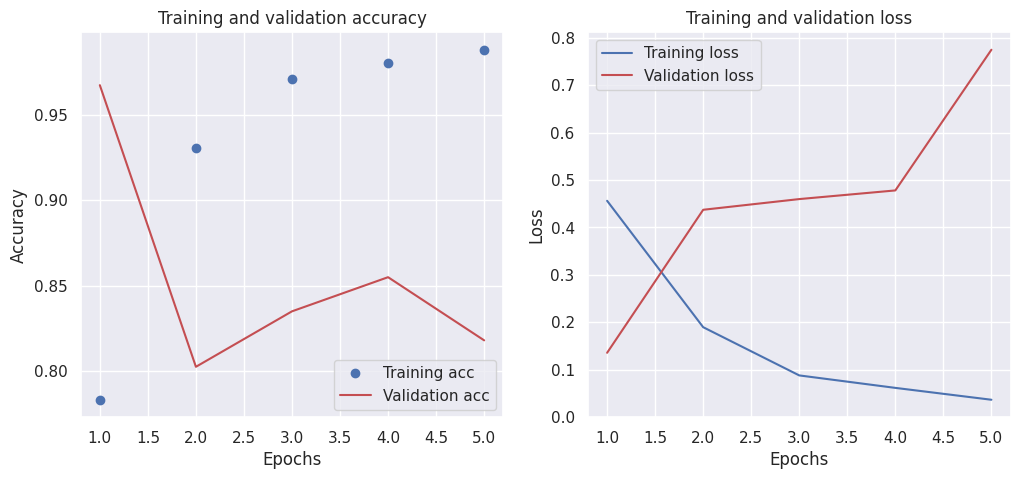

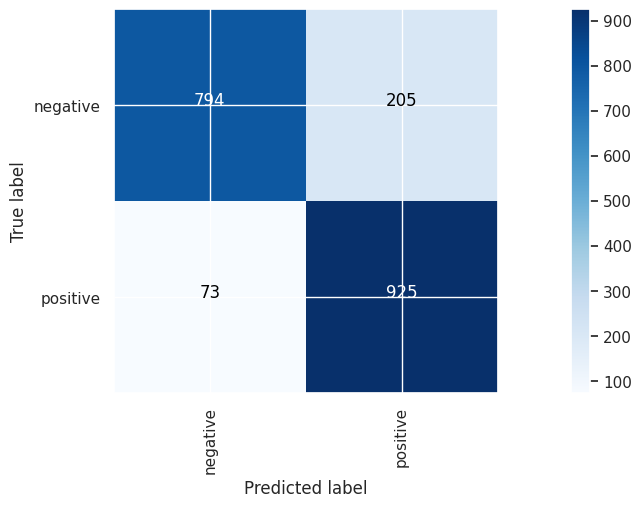

Final Accuracy
0.8607911867801703
Model: "Exp05StackedRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 64)                7360      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 1496140 (5.71 MB)
Trainable params: 1496140 (5.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/5
250/250 [==============================] - 91s 363ms/step - loss: 0.5799 - accuracy: 0.6981 - va

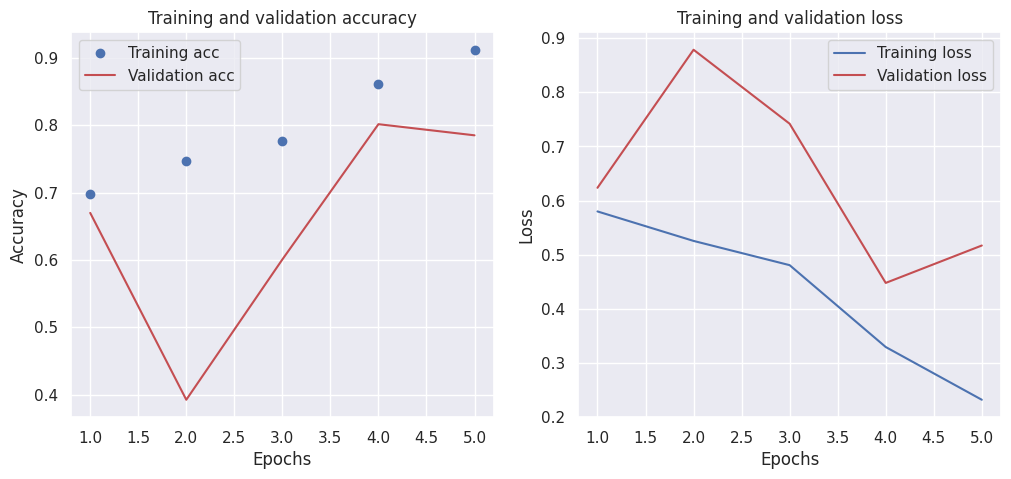

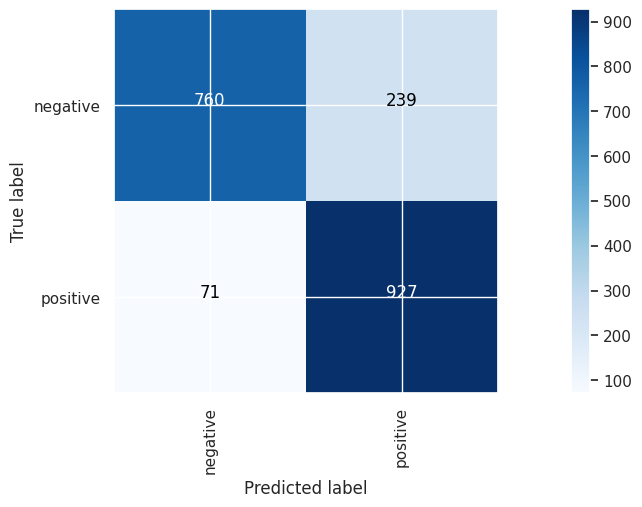

Final Accuracy
0.8447671507260891


In [9]:
results = []
name = "StackedRNN"
description =   """
                layers_units=[64, 64],
                extra_dense_layer_nn=0,
                extra_dense_dropout_layer=0.0,
                dropout=[0.0, 0.0],
                recurrent_dropout=[0.0, 0.0],
                kernel_regularizer=None
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[64, 64]
extra_dense_layer_nn=0
extra_dense_dropout_layer=0.0
dropout=[0.0, 0.0]
recurrent_dropout=[0.0, 0.0]
kernel_regularizer=None


# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp05(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            kernel_regularizer=kernel_regularizer         
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp05(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            kernel_regularizer=kernel_regularizer     
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_05_1.csv", index=False)

Model: "Exp05StackedRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding (Embedding)       (None, 600, 50)           1488650   
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 600, 64)           7360      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 1504396 (5.74 MB)
Trainable params: 1504396 (5.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/

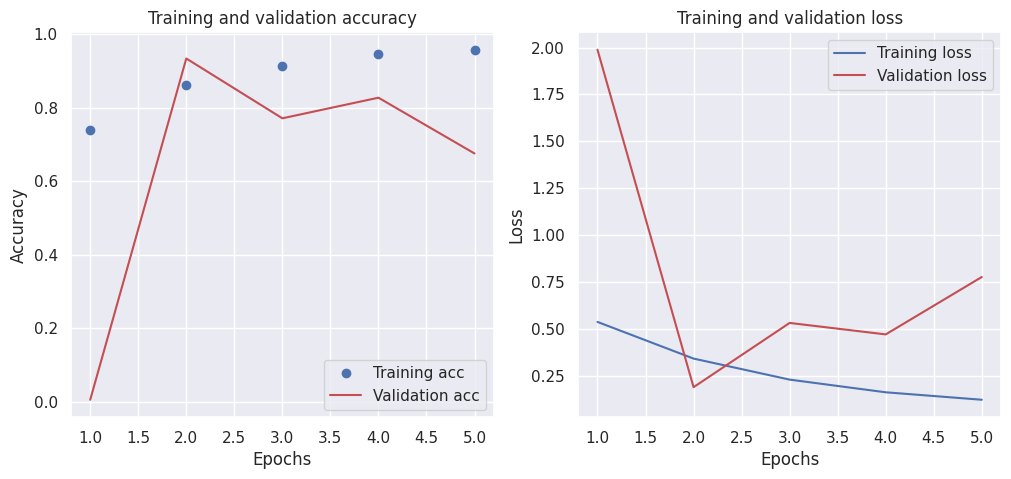

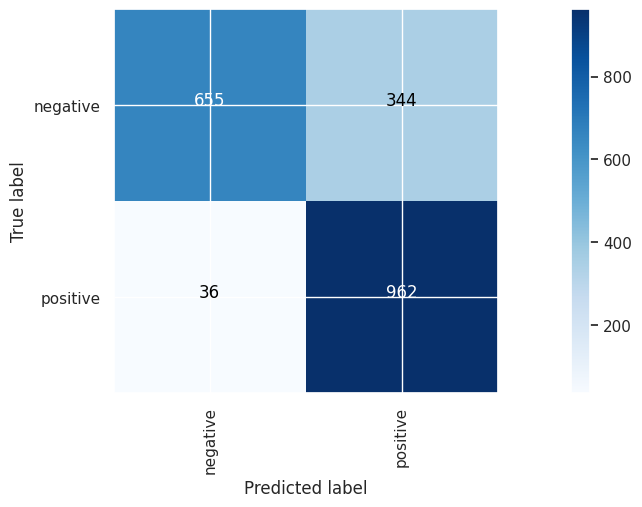

Final Accuracy
0.8097145718577867
Model: "Exp05StackedRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 64)                7360      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 1496140 (5.71 MB)
Trainable params: 1496140 (5.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 103s 408ms/step - loss: 0.5838 - accuracy: 0.6934 - 

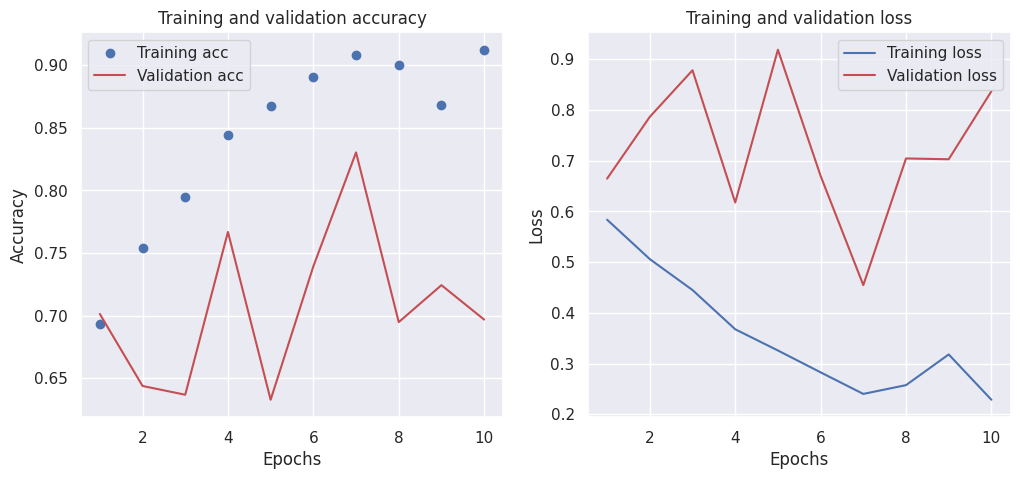

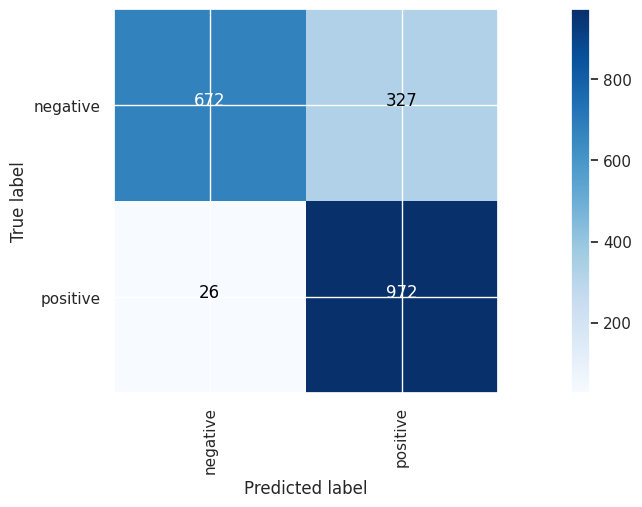

Final Accuracy
0.8232348522784176


In [8]:
results = []
name = "StackedRNN"
description =   """
                layers_units=[64, 64],
                extra_dense_layer_nn=0,
                extra_dense_dropout_layer=0.0,
                dropout=[0.3, 0.3],
                recurrent_dropout=[0.0, 0.0],
                kernel_regularizer=None
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[64, 64]
extra_dense_layer_nn=0
extra_dense_dropout_layer=0.0
dropout=[0.3, 0.3]
recurrent_dropout=[0.0, 0.0]
kernel_regularizer=None


# VSM models
# results = []
# for rep in vsm_model:
#     build_exp05(name,
#                 description, 
#                 rep, 
#                 input_shape=(5000,1,),
#                 layers_units=layers_units,
#                 extra_dense_layer_nn=extra_dense_layer_nn,
#                 extra_dense_dropout_layer=extra_dense_dropout_layer,
#                 dropout=dropout,
#                 recurrent_dropout=recurrent_dropout,
#                 kernel_regularizer=kernel_regularizer
#                 )

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp05(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            kernel_regularizer=kernel_regularizer         
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp05(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            kernel_regularizer=kernel_regularizer     
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_05_2.csv", index=False)

Model: "Exp05StackedRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 600, 16)           1072      
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 2)                 34        
                                                                 
Total params: 1490284 (5.68 MB)
Trainable params: 1490284 (5.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/

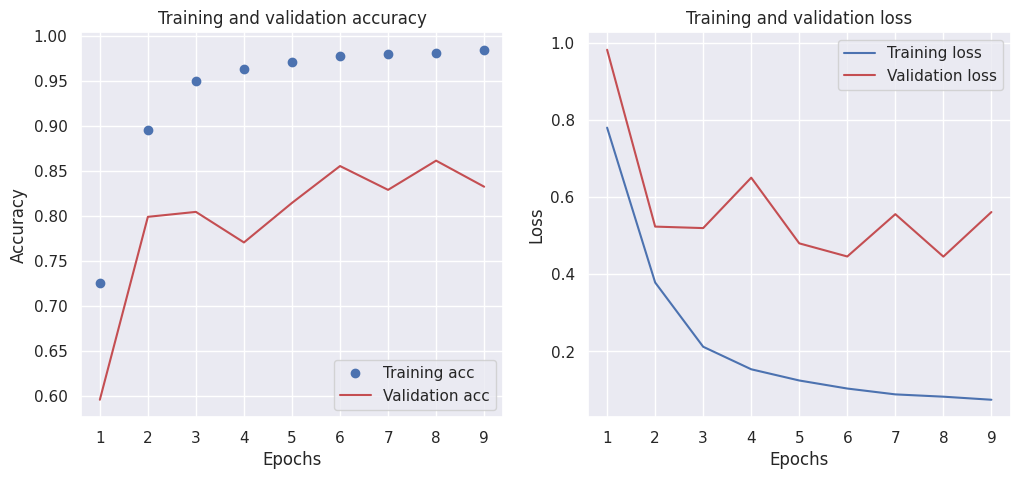

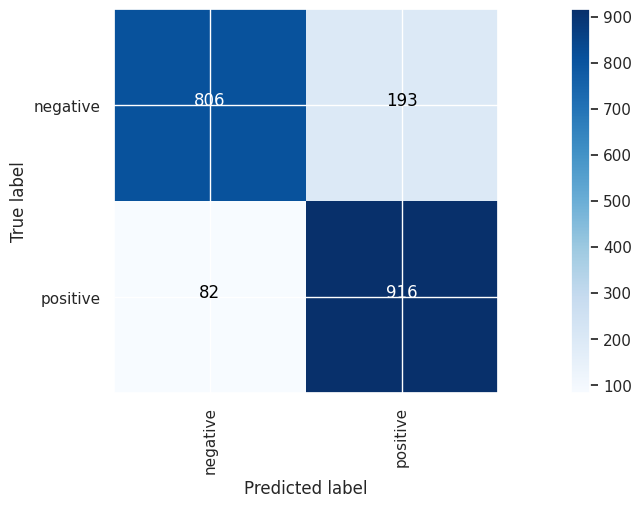

Final Accuracy
0.8622934401602403
Model: "Exp05StackedRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 16)                1072      
                                                                 
 dense_5 (Dense)             (None, 2)                 34        
                                                                 
Total params: 1489756 (5.68 MB)
Trainable params: 1489756 (5.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 100s 394ms/step - loss: 0.7919 - accuracy: 0.6516 - 

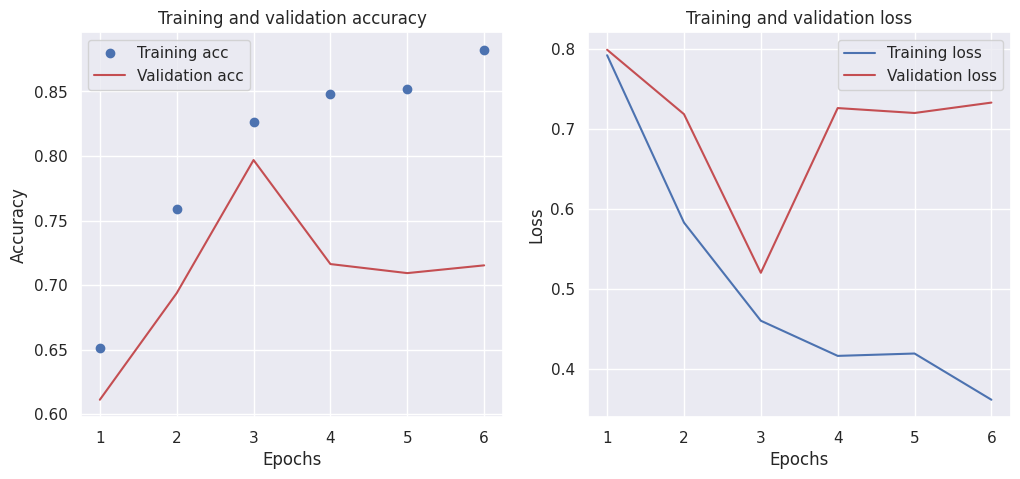

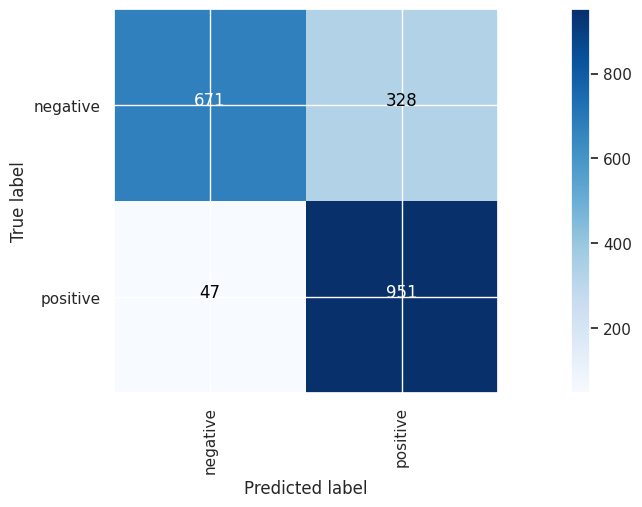

Final Accuracy
0.8122183274912369


In [10]:
results = []
name = "StackedRNN"
description =   """
                layers_units=[16, 16],
                extra_dense_layer_nn=0,
                extra_dense_dropout_layer=0.0,
                dropout=[0.3, 0.3],
                recurrent_dropout=[0.0, 0.0],
                kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[16, 16]
extra_dense_layer_nn=0
extra_dense_dropout_layer=0.0
dropout=[0.3, 0.3]
recurrent_dropout=[0.0, 0.0]
kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)


# VSM models
# results = []
# for rep in vsm_model:
#     build_exp05(name,
#                 description, 
#                 rep, 
#                 input_shape=(5000,1,),
#                 layers_units=layers_units,
#                 extra_dense_layer_nn=extra_dense_layer_nn,
#                 extra_dense_dropout_layer=extra_dense_dropout_layer,
#                 dropout=dropout,
#                 recurrent_dropout=recurrent_dropout,
#                 kernel_regularizer=kernel_regularizer
#                 )

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp05(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            kernel_regularizer=kernel_regularizer         
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp05(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            kernel_regularizer=kernel_regularizer     
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_05_3.csv", index=False)

Model: "Exp05StackedRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 600, 8)            472       
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 8)                 136       
                                                                 
 dense_6 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1489276 (5.68 MB)
Trainable params: 1489276 (5.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/

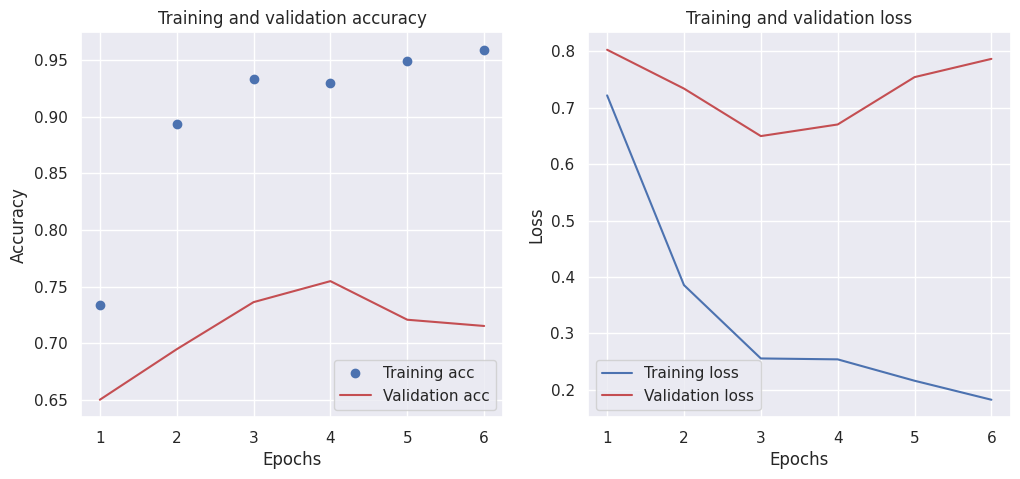

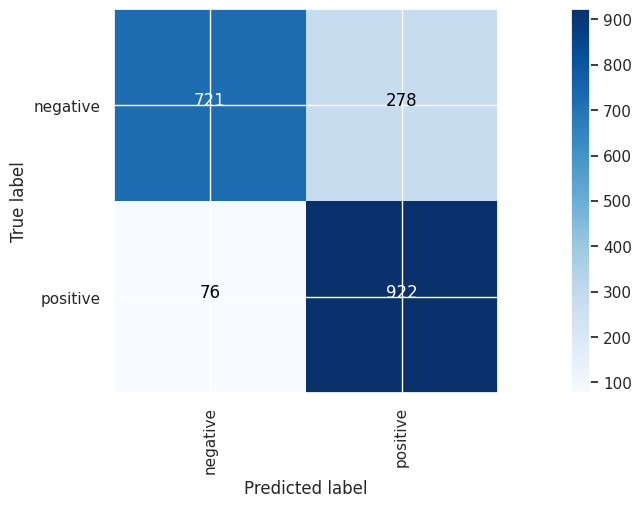

Final Accuracy
0.8227341011517276
Model: "Exp05StackedRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, 8)                 472       
                                                                 
 dense_7 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1489140 (5.68 MB)
Trainable params: 1489140 (5.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 103s 408ms/step - loss: 0.7687 - accuracy: 0.6267 - 

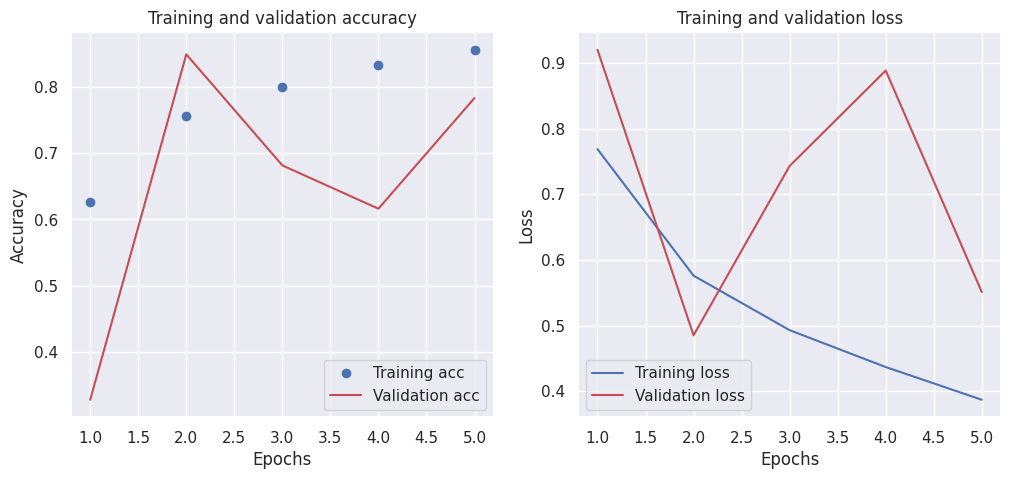

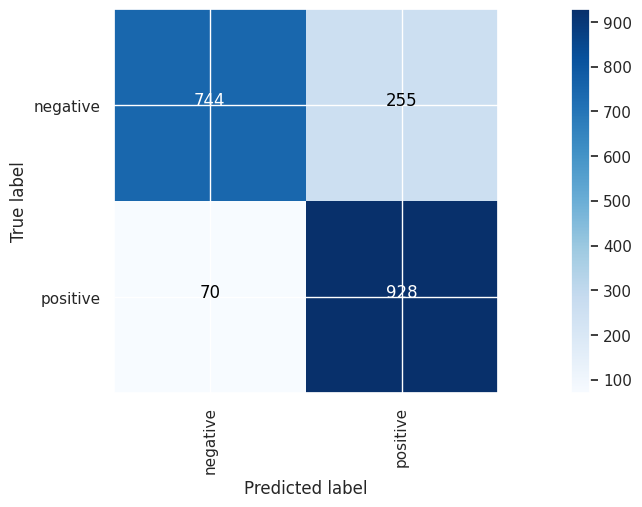

Final Accuracy
0.8372558838257386


In [11]:
results = []
name = "StackedRNN"
description =   """
                layers_units=[8, 8],
                extra_dense_layer_nn=0,
                extra_dense_dropout_layer=0.0,
                dropout=[0.3, 0.3],
                recurrent_dropout=[0.0, 0.0],
                kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[8, 8]
extra_dense_layer_nn=0
extra_dense_dropout_layer=0.0
dropout=[0.3, 0.3]
recurrent_dropout=[0.0, 0.0]
kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)


# VSM models
# results = []
# for rep in vsm_model:
#     build_exp05(name,
#                 description, 
#                 rep, 
#                 input_shape=(5000,1,),
#                 layers_units=layers_units,
#                 extra_dense_layer_nn=extra_dense_layer_nn,
#                 extra_dense_dropout_layer=extra_dense_dropout_layer,
#                 dropout=dropout,
#                 recurrent_dropout=recurrent_dropout,
#                 kernel_regularizer=kernel_regularizer
#                 )

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp05(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            kernel_regularizer=kernel_regularizer         
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp05(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            kernel_regularizer=kernel_regularizer     
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_05_4.csv", index=False)

Model: "Exp05StackedRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 600)]             0         
                                                                 
 embedding_7 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 600, 2)            106       
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 2)                 10        
                                                                 
 dense_8 (Dense)             (None, 2)                 6         
                                                                 
Total params: 1488772 (5.68 MB)
Trainable params: 1488772 (5.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/

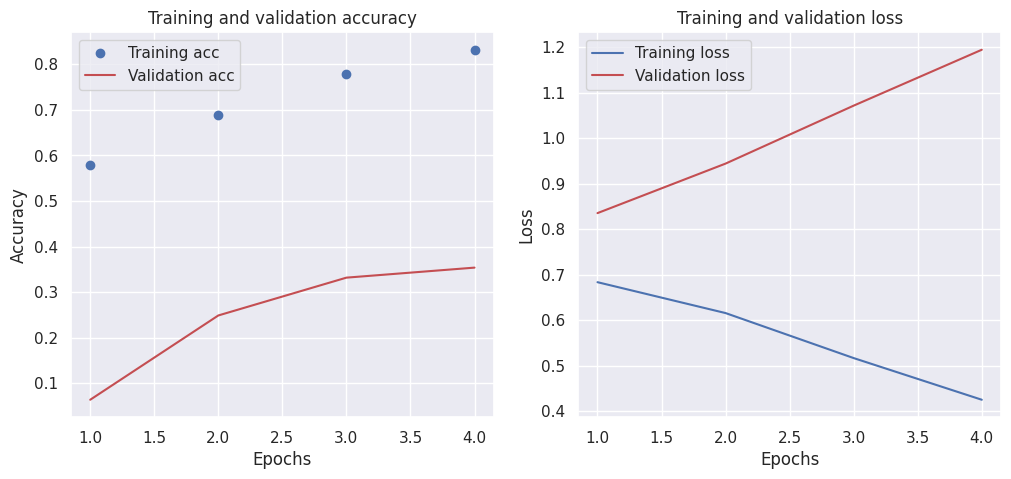

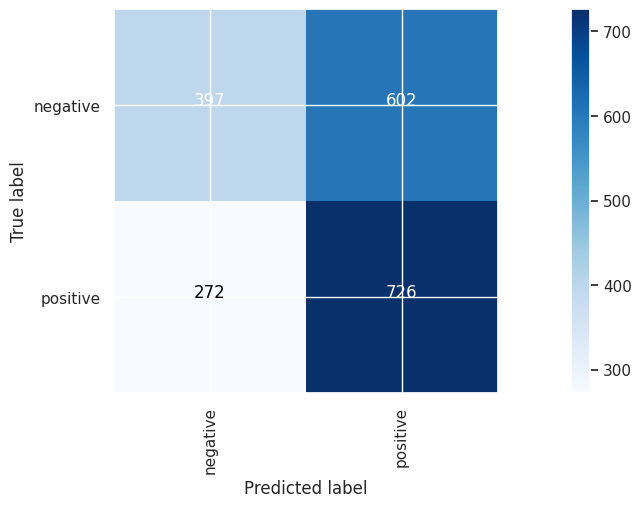

Final Accuracy
0.5623435152729094
Model: "Exp05StackedRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_8 (Embedding)     (None, 600, 50)           1488650   
                                                                 
 simple_rnn_15 (SimpleRNN)   (None, 2)                 106       
                                                                 
 dense_9 (Dense)             (None, 2)                 6         
                                                                 
Total params: 1488762 (5.68 MB)
Trainable params: 1488762 (5.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/40
250/250 [==============================] - 101s 402ms/step - loss: 0.6795 - accuracy: 0.6061 - 

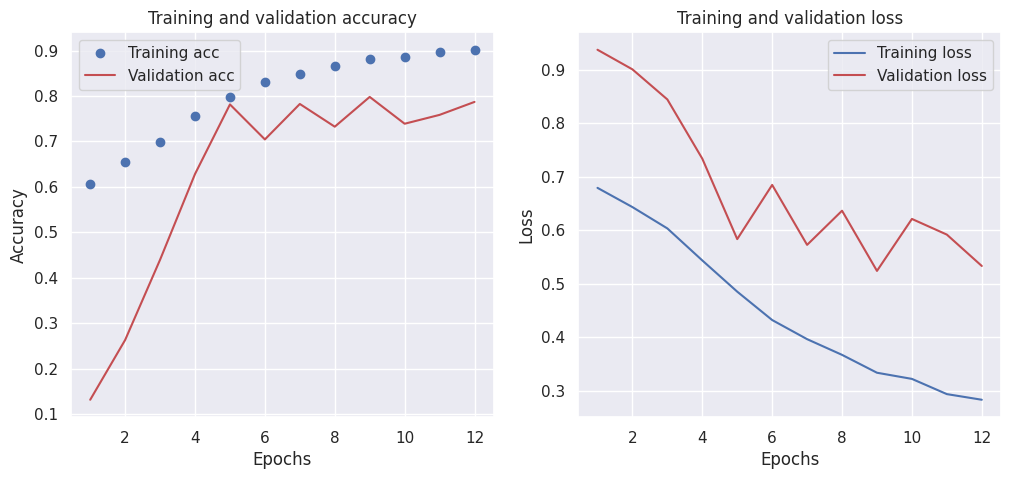

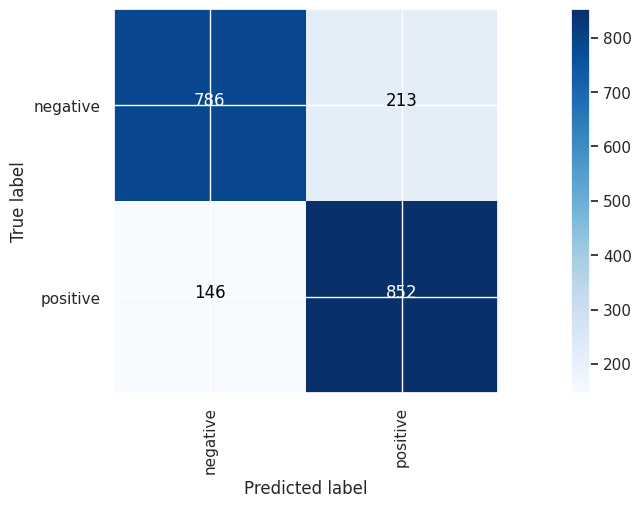

Final Accuracy
0.8202303455182774


In [12]:
results = []
name = "StackedRNN"
description =   """
                layers_units=[2, 2],
                extra_dense_layer_nn=0,
                extra_dense_dropout_layer=0.0,
                dropout=[0.3, 0.3],
                recurrent_dropout=[0.0, 0.0],
                kernel_regularizer=None
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

layers_units=[2, 2]
extra_dense_layer_nn=0
extra_dense_dropout_layer=0.0
dropout=[0.3, 0.3]
recurrent_dropout=[0.0, 0.0]
kernel_regularizer=kernel_regularizer=None


# VSM models
# results = []
# for rep in vsm_model:
#     build_exp05(name,
#                 description, 
#                 rep, 
#                 input_shape=(5000,1,),
#                 layers_units=layers_units,
#                 extra_dense_layer_nn=extra_dense_layer_nn,
#                 extra_dense_dropout_layer=extra_dense_dropout_layer,
#                 dropout=dropout,
#                 recurrent_dropout=recurrent_dropout,
#                 kernel_regularizer=kernel_regularizer
#                 )

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp05(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            kernel_regularizer=kernel_regularizer         
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp05(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            layers_units=layers_units,
            extra_dense_layer_nn=extra_dense_layer_nn,
            extra_dense_dropout_layer=extra_dense_dropout_layer,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            kernel_regularizer=kernel_regularizer     
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_05_5.csv", index=False)

## Conclusiones

In [13]:
join_csv_for_experiment("05", 5)
pd.read_csv("exp_05.csv").sort_values(by=["accuracy"], ascending=False, ignore_index=True)[["classifier", "rep.model", "accuracy","precision","recall"]]

,classifier,rep.model,accuracy,precision,recall
0,"Exp05StackedRNN layers_units=[16,16],extra_dense_layer_nn=0,extra_dense_dropout_layer=0.0,dropout=[0.3,0.3],recurrent_dropout=[0.0,0.0],kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)",Word embedding: tokenizando el texto en secuencias y pad_sequences,0.862293,0.866834,0.862293
1,"Exp05StackedRNN layers_units=[64,64],extra_dense_layer_nn=0,extra_dense_dropout_layer=0.0,dropout=[0.0,0.0],recurrent_dropout=[0.0,0.0],kernel_regularizer=None",Word embedding: tokenizando el texto en secuencias y pad_sequences,0.860791,0.867217,0.860791
2,"Exp05StackedRNN layers_units=[64,64],extra_dense_layer_nn=0,extra_dense_dropout_layer=0.0,dropout=[0.0,0.0],recurrent_dropout=[0.0,0.0],kernel_regularizer=None",Word embedding with GloVe,0.844767,0.854823,0.844767
3,"Exp05StackedRNN layers_units=[8,8],extra_dense_layer_nn=0,extra_dense_dropout_layer=0.0,dropout=[0.3,0.3],recurrent_dropout=[0.0,0.0],kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)",Word embedding with GloVe,0.837256,0.849258,0.837256
4,"Exp05StackedRNN layers_units=[64,64],extra_dense_layer_nn=0,extra_dense_dropout_layer=0.0,dropout=[0.3,0.3],recurrent_dropout=[0.0,0.0],kernel_regularizer=None",Word embedding with GloVe,0.823235,0.855563,0.823235
5,"Exp05StackedRNN layers_units=[8,8],extra_dense_layer_nn=0,extra_dense_dropout_layer=0.0,dropout=[0.3,0.3],recurrent_dropout=[0.0,0.0],kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)",Word embedding: tokenizando el texto en secuencias y pad_sequences,0.822734,0.836522,0.822734
6,"Exp05StackedRNN layers_units=[2,2],extra_dense_layer_nn=0,extra_dense_dropout_layer=0.0,dropout=[0.3,0.3],recurrent_dropout=[0.0,0.0],kernel_regularizer=None",Word embedding with GloVe,0.820230,0.821685,0.820230
7,"Exp05StackedRNN layers_units=[16,16],extra_dense_layer_nn=0,extra_dense_dropout_layer=0.0,dropout=[0.3,0.3],recurrent_dropout=[0.0,0.0],kernel_regularizer=kernel_regularizer=regularizers.l2(0.01)",Word embedding with GloVe,0.812218,0.839093,0.812218
8,"Exp05StackedRNN layers_units=[64,64],extra_dense_layer_nn=0,extra_dense_dropout_layer=0.0,dropout=[0.3,0.3],recurrent_dropout=[0.0,0.0],kernel_regularizer=None",Word embedding: tokenizando el texto en secuencias y pad_sequences,0.809715,0.842304,0.809715
9,"Exp05StackedRNN layers_units=[2,2],extra_dense_layer_nn=0,extra_dense_dropout_layer=0.0,dropout=[0.3,0.3],recurrent_dropout=[0.0,0.0],kernel_regularizer=None",Word embedding: tokenizando el texto en secuencias y pad_sequences,0.562344,0.570067,0.562344
